In this notebook, we'll bring together both models that we've trained - The YOLOv3 model to detect the location of the dog in the image, trained [here](./train.ipynb) and the classifier InceptionV3 Model to identify the dog breed, trained [here](https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation). We'll first use the YOLO model to crop the relevant images before testing our classification.

In [9]:
from detect import *
from classifier import *

import os
import shutil
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable

Defining functions to display data

In [10]:
def parse_output(name):
    file = open("output/" + name + ".txt", "r")
    data = file.read()[:-1].split()
    xmin = data[0]
    ymin = data[1]
    xmax = data[2]
    ymax = data[3]
    return xmin, xmax, ymin, ymax

In [11]:
def crop_and_save(xmin, xmax, ymin, ymax, dog):
    if not "crop_samples" in os.listdir('data'):
        os.makedirs('data/crop_samples')
    img = Image.open('data/samples/' + dog + '.jpg')
    img = img.crop((float(xmin),float(ymin),float(xmax),float(ymax)))
    img = img.convert('RGB')
    img.save('data/crop_samples/' + dog + '.jpg')

In [12]:
def prepare_samples(n_samples):
    shutil.rmtree('data/samples')
    os.makedirs('data/samples')
    breed_list = os.listdir('data/Annotation')
    dogs = []
    for i in range(n_samples):
        breed = np.random.choice(breed_list)
        dog = np.random.choice(os.listdir('data/Annotation/' + breed))
        shutil.copyfile(src="data/images/"+breed+"/"+dog+".jpg", dst="data/samples/"+dog+".jpg")
        dogs.append(dog)
    return dogs

We'll now use the YOLO model to identify the locations of the dogs in the images

In [45]:
n_samples = 4
dogs = prepare_samples(n_samples)
detect('cfg/yolov3.cfg', 'weights/latest.pt', 'data/samples')

Using cpu 

image 1/4 data/samples\n02089078_663.jpg: 1 dogs, Done. (3.691s)
image 2/4 data/samples\n02100877_4699.jpg: 1 dogs, Done. (2.881s)
image 3/4 data/samples\n02105505_1406.jpg: 1 dogs, Done. (2.783s)
image 4/4 data/samples\n02116738_8945.jpg: 1 dogs, Done. (2.592s)


The bounding boxes are drawn on the images and the images are then cropped so that it can be fed to the classifier subsequently

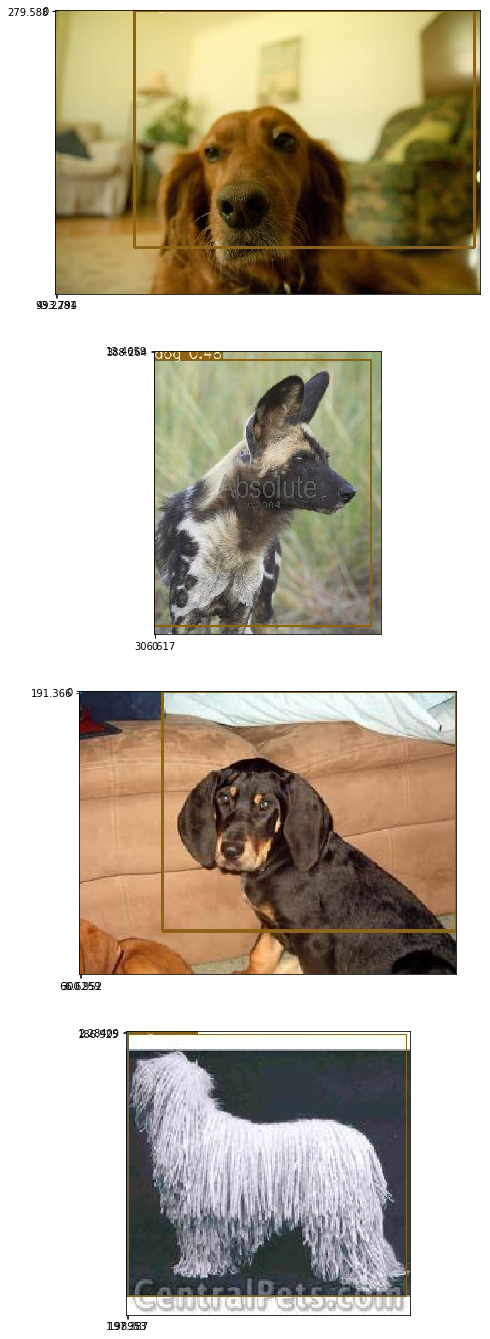

In [46]:
plt.figure(figsize=(10, n_samples * 6))
if "crop_samples" in os.listdir('data'):
    shutil.rmtree('data/crop_samples')
os.makedirs('data/crop_samples')
for i, dog in enumerate(dogs):
    plt.subplot(len(dogs)*100 + 11 + i)
    img = plt.imread('output/' + dog + '.jpg')
    plt.imshow(img)
    try:
        xmin, xmax, ymin, ymax = parse_output(dog)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin])
        crop_and_save(xmin, xmax, ymin, ymax, dog)
    except:
        plt.text(10,15,'No Detection for this picture', bbox=dict(facecolor='red', alpha=0.5))

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [ ]:
def transform_img(dog):
    img = Image.open('data/crop_samples/'+dog)
    img = transform(img)
    img = img.unsqueeze(0)
    return img

In [ ]:
def classify(model, img):
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, pred = output.unsqueeze(0).topk(1)
        breed = model.idx_to_class[pred[0].item()]
    return breed

In [ ]:
def find_breed(code):
    breed_list = os.listdir('data/Annotation')
    for dog in breed_list:
        if code in dog:
            return dog

After defining some helper functions, we'll bring in the model that we trained in the [Kaggle kernel](https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation) to classify the dogs into their specific breed.

In [29]:
model = load_model()

We'll then plot the images and compare the predictions to the actual breed

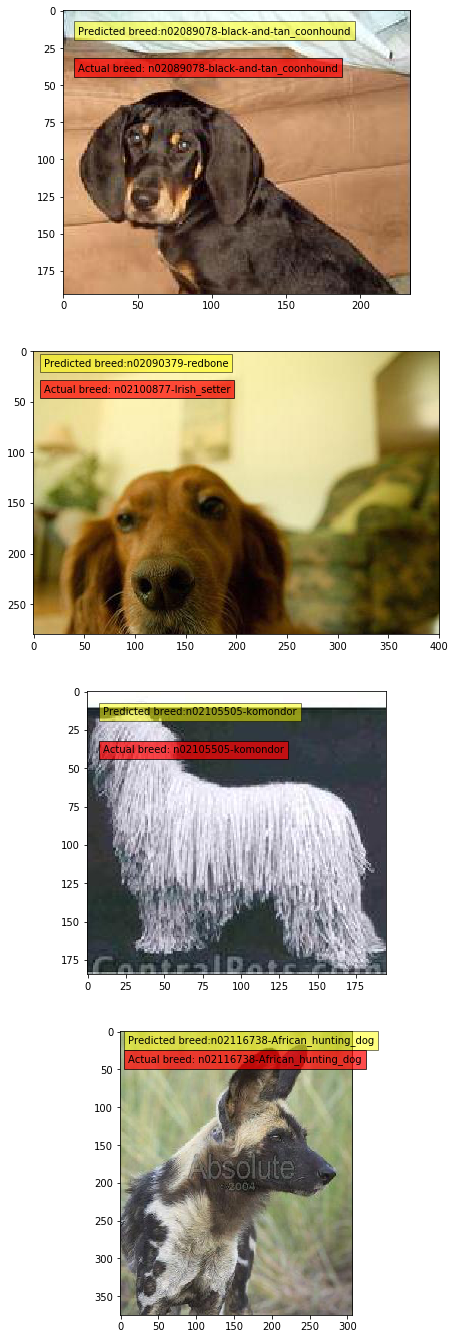

In [47]:
breed_list = os.listdir('data/Annotation')
plt.figure(figsize=(10, n_samples * 6))
for i, dog in enumerate(os.listdir('data/crop_samples')):
    if dog.endswith('.jpg'):
        try:
            img = transform_img(dog)
            breed = classify(model, img)
            plt.subplot(n_samples*100 + 11 + i)
            img = plt.imread('data/crop_samples/' + dog)
            plt.imshow(img)
            plt.text(10,15,'Predicted breed:' + breed, bbox=dict(facecolor='yellow', alpha=0.5))
            plt.text(10, 40, 'Actual breed: ' + find_breed(dog[:8]), bbox=dict(facecolor='red', alpha=0.7))
        except Exception as e:
            print(e)

From the 4 random examples above, the model managed to predict 3 of them to be correct. This is expected as our accuracy from our test set was around 75% as well.